# Final project
#### Niki Akhavanniaki (1990619)
#### Sepehr Abdi Goudarzi (1990044)

## __Importing the necessary packages__

In [9]:
# pandas dataframes
import pandas as pd

# reading the image and converting to the pixel values
import cv2

# using numpy arrasy
import numpy as np

# for plotting activities
import matplotlib.pyplot as plt

# to plot the confusion matrix of the predictions
from sklearn.metrics import confusion_matrix

# to plot some specific plots
import seaborn as sns

# to use the tensorflow
import tensorflow as tf

# to store the objects in .pickle files
import pickle

# different needed components of tensorflow
from tensorflow.keras import layers, losses, metrics, optimizers

# We will use the cifar10 datasets in this project
from keras.datasets import cifar10


# Data loading

We will load the CIFAR10 dataset from tensorflow.

In [2]:
# Loading the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In CIFAR10 available on tensorflow, the labels have been encoded. We will construct an encoding dictionary for the labels. The encodings can be [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)

In [3]:
# Creating a label encoding in our data
Label_encoding = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
                  5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

We will take a look at the dimension of the training and the test sets

In [4]:
# Taking a look at the data splits generated
print("Taking a look at the shape of each set that we are going to work with: ", end = '\n\n')
print("Training set (sampels):", X_train.shape)
print("Training set (labels):", y_train.shape)
print("Test set (sampels):", X_test.shape)
print("Test set (labels):", y_test.shape)

Taking a look at the shape of each set that we are going to work with: 

Training set (sampels): (50000, 32, 32, 3)
Training set (labels): (50000, 1)
Test set (sampels): (10000, 32, 32, 3)
Test set (labels): (10000, 1)


There are __50000__ samples in the __training set__, and __10000__ samples in __test set__.

## __Explanatory data analysis__

In this section we will check the distribution of our samples and some samples in our datset

### __Class distribution__

Checking the counts of each labels in each set

In [5]:
# Checking the number of samples for each label in the training set
unique_values_train, counts_train = np.unique(y_train, return_counts=True)
unique_values_test, counts_test = np.unique(y_test, return_counts=True)

Showing the distribution of the labels:

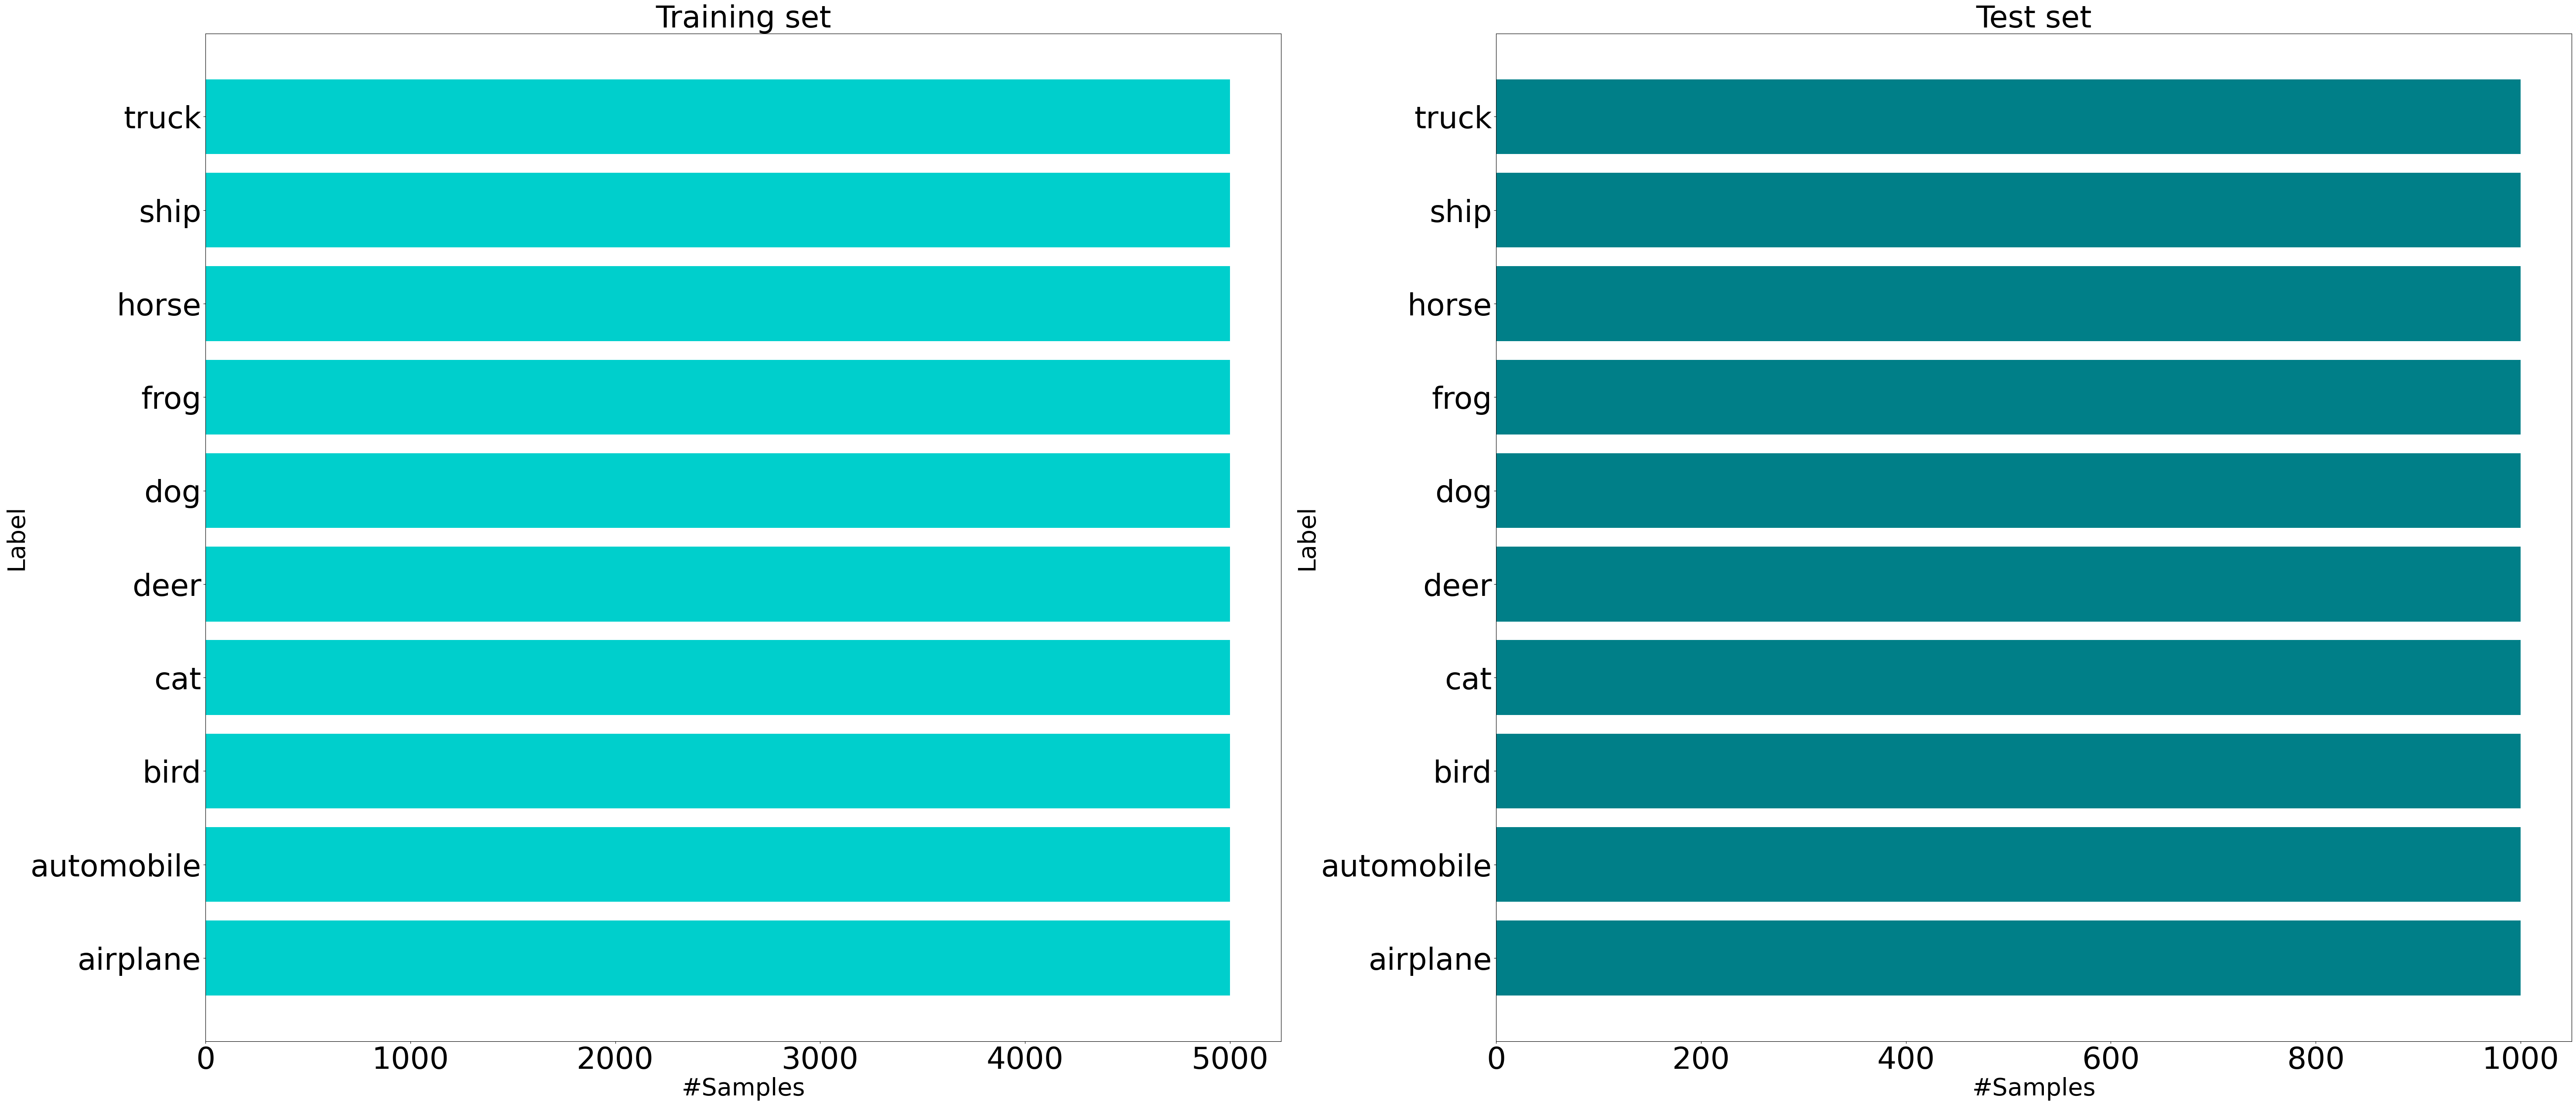

In [6]:
# Setting the paramters of the plots
plt.rcParams.update({'xtick.labelsize': 50,
                    'ytick.labelsize' : 50,
                    'axes.labelsize' : 40,
                    'axes.titlesize': 50
                    })


# Define dimensions for plot
f, axs = plt.subplots(1, 2,figsize=(70,30))
axs = axs.flatten()

# Showing the distribution of the labels in the training set
axs[0].barh(list(map(lambda x: Label_encoding[x], unique_values_train)), counts_train, alpha = 1, color = "#00cfcc")
axs[0].set_xlabel('#Samples')
axs[0].set_ylabel('Label')
axs[0].set_title('Training set')

# Showing the distribution of the labels in the test set
axs[1].barh(list(map(lambda x: Label_encoding[x], unique_values_test)), counts_test, alpha = 1, color = "#007f88")
axs[1].set_xlabel('#Samples')
axs[1].set_ylabel('Label')
axs[1].set_title('Test set')


# Plot the data distribution for this specific data partitioning
plt.show()


From the plots above, we can see that for each label we have __5000__ samples in training and __1000__ in the test set.

Then we will take a look at 5 samples for each label in the training set

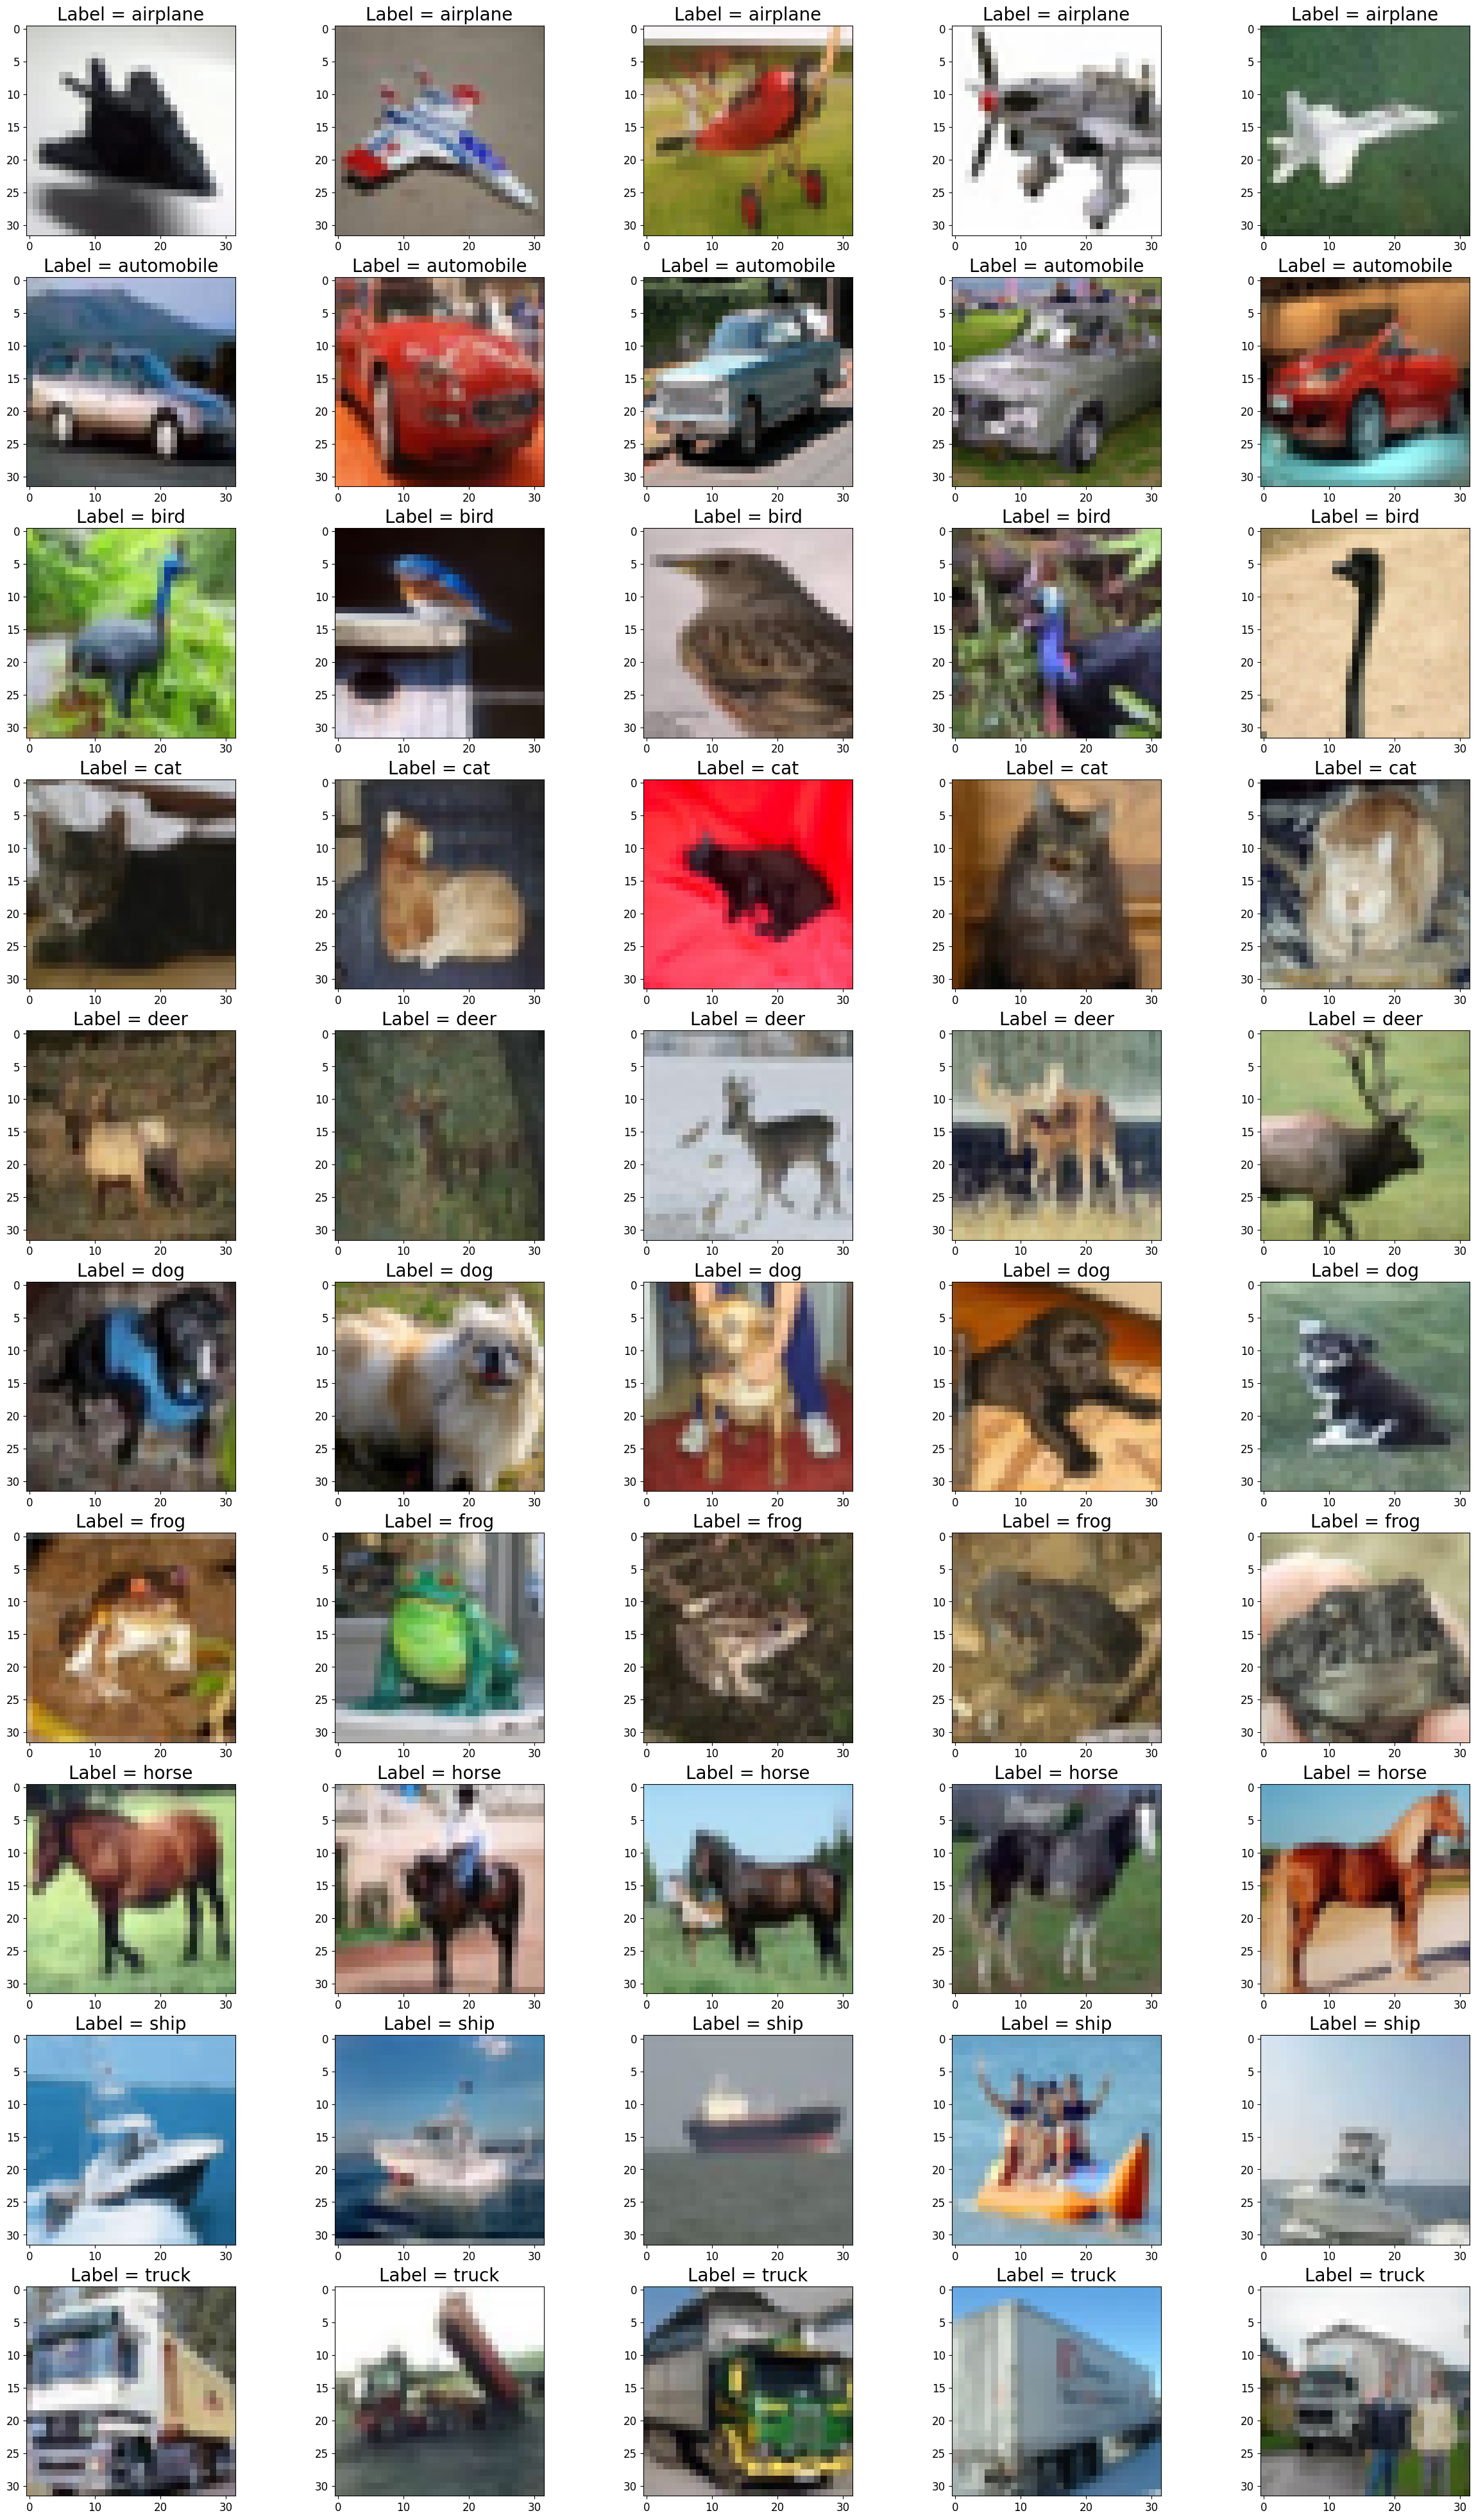

In [8]:
# Setting the parameters of the plots
plt.rcParams.update({'xtick.labelsize': 12,
                    'ytick.labelsize' : 12,
                    'axes.labelsize' : 12,
                    'axes.titlesize': 20,
                    'figure.figsize': (30, 50)})

# Making the subplots
fg, ax = plt.subplots(10, 5)

# For each label show 5 images
for label_index, label in enumerate(unique_values_train):

  # Get the samples from that label
  mask = y_train == label

  # Finding the index of the samples
  samples_index = np.where(mask)[0]

  # Show the first 5 images for that label
  for show_index in range(5):

    # Show the image
    ax[label_index][show_index].imshow(X_train[samples_index[show_index], : , : , :])

    # Set the title of the image
    ax[label_index][show_index].title.set_text(f'Label = {Label_encoding[label]}')


## __Image to tensor__

Now in order to speed up the training process, we will convert our data into tensors

In [10]:
# We will convert the numpy arrays to tensors for faster computation
X_train, y_train, X_test, y_test = tf.convert_to_tensor(X_train, dtype=tf.float64),  tf.convert_to_tensor(y_train,  dtype=tf.float64), tf.convert_to_tensor(X_test,  dtype=tf.float64), tf.convert_to_tensor(y_test,  dtype=tf.float64)

## __Data splitting__

As we have seen before, we have __'50000'__ samples in the training and __'10000'__ samples in the test set. We will use __'10000'__ of our training set as validation set to check the peformance of the model on unseen data during the training process.

In [11]:
# Splitting the initial training set to two sets, training and validation sets
X_train, X_valid = tf.split(X_train, [40000, 10000], axis = 0) # splitting the samples
y_train, y_valid = tf.split(y_train, [40000, 10000], axis = 0 ) # splitting the labels

Now again we will check the dimension of our 3 sets:

In [12]:
# Taking a look at the data splits generated
print("Taking a look at the shape of each set that we are going to work with: ", end = '\n\n')
print("Training set (sampels):", X_train.shape)
print("Training set (labels):", y_train.shape)
print("Validation set (sampels):", X_valid.shape)
print("Validation set (labels):", y_valid.shape)
print("Test set (sampels):", X_test.shape)
print("Test set (labels):", y_test.shape)

Taking a look at the shape of each set that we are going to work with: 

Training set (sampels): (40000, 32, 32, 3)
Training set (labels): (40000, 1)
Validation set (sampels): (10000, 32, 32, 3)
Validation set (labels): (10000, 1)
Test set (sampels): (10000, 32, 32, 3)
Test set (labels): (10000, 1)


#__Model without early exits__

Our netowrk would consist of the following blocks:
  1. 3 convolutional blocks with the filter size of 64, 128, 256 in order which each of them consist of the following layers:
    - Convolutional layer
    - MaxPool layer
    - BatchNormalization layer
    - Dropout layer
  2. Classifying block consisting of the following layers:
    - 2 Dense layers of 64, 32 neurons
    - 1 Dense output layer with 10 neurons and using softmax as the activation

In [13]:
# Implementing a class for our model to give us more flexibility
class Model(tf.keras.Model):

  # constructor of the class
  def __init__(self):

    # call the constructor of the model class
    super(Model, self).__init__()

    # first convolution block
    self.Conv1 = layers.Conv2D(64, 3, padding='same', activation = 'relu')
    self.MaxPool1 = layers.MaxPool2D(2)
    self.BatchNorm1 = layers.BatchNormalization()
    self.Drop1 = layers.Dropout(0.3)

    # second convolution block
    self.Conv2 = layers.Conv2D(128, 3, padding='same', activation = 'relu')
    self.MaxPool2 = layers.MaxPool2D(2)
    self.BatchNorm2 = layers.BatchNormalization()
    self.Drop2 = layers.Dropout(0.3)

    # third convolution block
    self.Conv3 = layers.Conv2D(256, 3, padding='same', activation = 'relu')
    self.MaxPool3 = layers.MaxPool2D(2)
    self.BatchNorm3 = layers.BatchNormalization()
    self.Drop3 = layers.Dropout(0.3)

    # Global Average pooling layer
    self.GlobAvg = layers.GlobalAvgPool2D()

    # Dense layer2
    self.Dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.Dense2 = tf.keras.layers.Dense(32, activation='relu')

    # Output layer
    self.Out = layers.Dense(10, activation='softmax')

  # how the data should be processed during the training and inference
  def call(self, inputs):

    #inputs = tf.keras.layers.Rescaling(scale = 1./ 255, input_shape = (32, 32, 3))(inputs)

    # First convolution block
    x = self.Drop1(self.BatchNorm1(self.MaxPool1(self.Conv1(inputs))))

    # Second convolution block
    x = self.Drop2(self.BatchNorm2(self.MaxPool2(self.Conv2(x))))

    # Third convolution block
    x = self.Drop3(self.BatchNorm3(self.MaxPool3(self.Conv3(x))))

    # Dense Layers
    x = self.Dense2(self.Dense1(self.GlobAvg(x)))

    return self.Out(x) # Return the output of the last classifying layer

## Model Creation

In [14]:
# Get an instance of the model by setting the parameters
model = Model()

# Setting the optimizer, loss function and the metrics that should be tracked for the model
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## Model fit

In [15]:
# Training the model by passing the training data and validation data for 70 epochs
model_history = model.fit(X_train, y_train, epochs = 70, validation_data = (X_valid, y_valid), batch_size = 256)

Epoch 1/70
157/157 [==============================] - 19s 33ms/step - loss: 1.5956 - accuracy: 0.4195 - val_loss: 2.0234 - val_accuracy: 0.3339
Epoch 2/70
157/157 [==============================] - 5s 30ms/step - loss: 1.2323 - accuracy: 0.5585 - val_loss: 1.4810 - val_accuracy: 0.4940
Epoch 3/70
157/157 [==============================] - 4s 28ms/step - loss: 1.0791 - accuracy: 0.6134 - val_loss: 1.4414 - val_accuracy: 0.5199
Epoch 4/70
157/157 [==============================] - 5s 30ms/step - loss: 0.9770 - accuracy: 0.6501 - val_loss: 2.1730 - val_accuracy: 0.3544
Epoch 5/70
157/157 [==============================] - 5s 29ms/step - loss: 0.8984 - accuracy: 0.6796 - val_loss: 1.1131 - val_accuracy: 0.6043
Epoch 6/70
157/157 [==============================] - 4s 28ms/step - loss: 0.8357 - accuracy: 0.7028 - val_loss: 1.0195 - val_accuracy: 0.6535
Epoch 7/70
157/157 [==============================] - 5s 29ms/step - loss: 0.7882 - accuracy: 0.7211 - val_loss: 0.8377 - val_accuracy: 0.708

## Training and validation check - loss and accuracy

First we can take a look at the changes in the __loss__ and the __accuracy__ for the __training__ and __validation__ sets during the training of the model

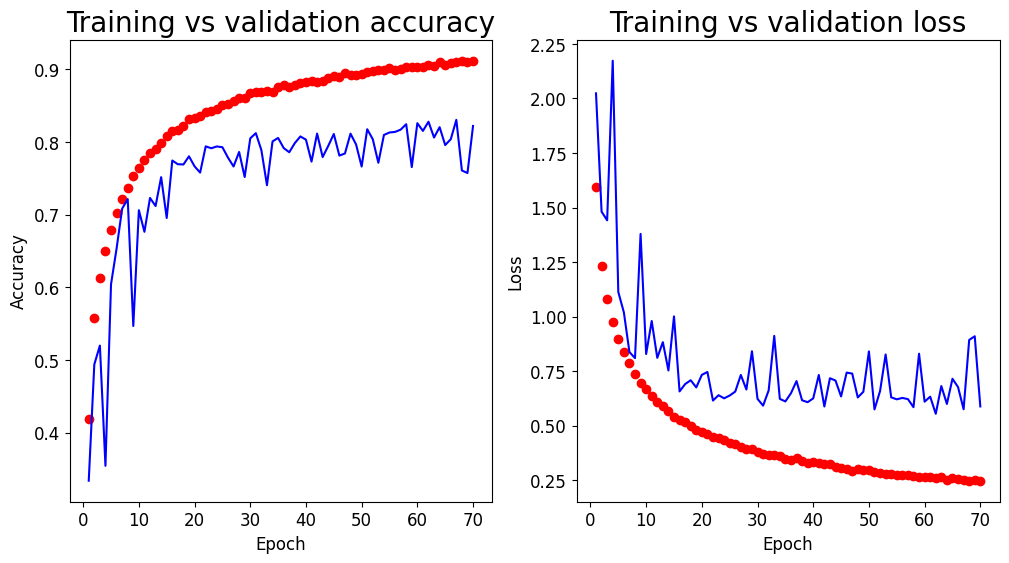

In [16]:
# Setting the parameters of the plots
plt.rcParams.update({'xtick.labelsize': 12,
                    'ytick.labelsize' : 12,
                    'axes.labelsize' : 12,
                    'axes.titlesize': 20,
                    'figure.figsize': (12, 6)})

# Take the evolution of the accuracy of the model on the training set
Training_acc = model_history.history['accuracy']

# Take the evolution of the accuracy of the model on the validation set
Validation_acc = model_history.history['val_accuracy']

# Take the evolution of the loss of the model on the training set
Training_loss = model_history.history['loss']

# Take the evolution of the loss of the model on the validation set
Validation_loss = model_history.history['val_loss']

# Generating the range for the epochs for the x axis
epochs = range(1, len(Training_acc) + 1)


# Define dimensions for plot
f, axs = plt.subplots(1, 2)
axs = axs.flatten()

# Showing the distribution of the labels in the training set
axs[0].plot(range(1, 71), Training_acc, 'ro', label='Training accuracy' )
axs[0].plot(range(1, 71), Validation_acc, 'b', label='Validation accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training vs validation accuracy')

# Showing the distribution of the labels in the training set
axs[1].plot(range(1, 71), Training_loss, 'ro', label='Training loss' )
axs[1].plot(range(1, 71), Validation_loss, 'b', label='Validation loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training vs validation loss')

plt.show()


## Accuracy check - test set

Now we are going to check the performance of the model on the test set:

In [17]:
# Accuracy of the model on the test set
print('Accuracy of the model over the test set: ' , round(model.evaluate(X_test, y_test)[1] * 100, 2), '%')

313/313 [==============================] - 2s 7ms/step - loss: 0.5872 - accuracy: 0.8218
Accuracy of the model over the test set:  82.18 %


Our model is good enough. It has __80%__ of accuracy over the test set.

## Confusion matrix - test set

313/313 [==============================] - 1s 2ms/step


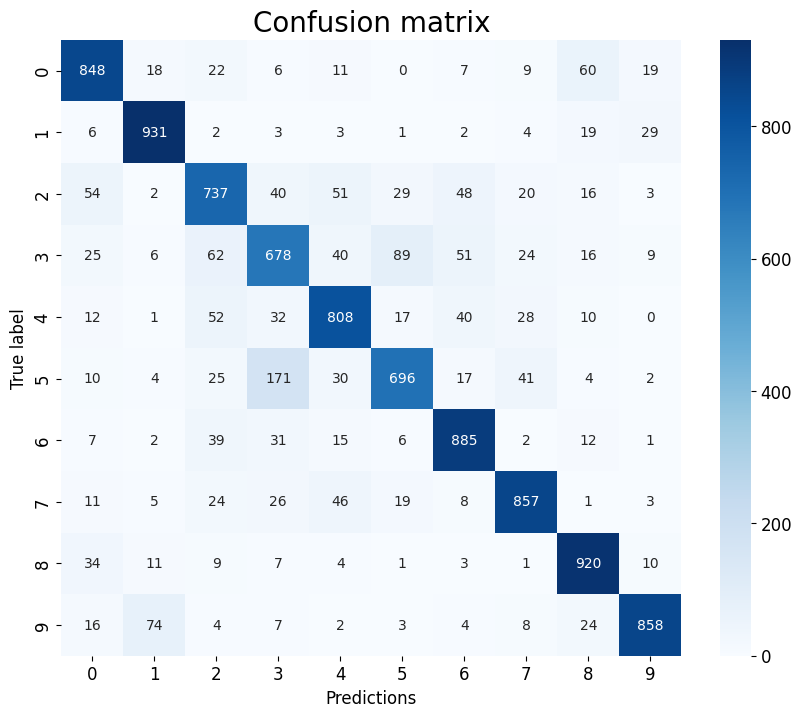

In [18]:
# Setting the parameters of the plots
plt.rcParams.update({'xtick.labelsize': 12,
                    'ytick.labelsize' : 12,
                    'axes.labelsize' : 12,
                    'axes.titlesize': 20,
                    'figure.figsize': (8, 6)})
# Get the logits of for the test data
y_pred = model.predict(X_test) # 10

# Find the predicted class for each sample in the test data
y_pred = np.argmax(y_pred, axis=1)

# Form the confusion matrix based on the predicted label and the true label
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title("Confusion matrix")
plt.show()

Taking a look at the number of the parameters that have been trained for this model:

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0     

# __Model with early exits__

The presence of early exits in the network would provide us with several advantages, including the ability to design layered training strategies, improve inference phase efficiency, and regularize for computational cost.

To capitalize on the presence of early exits in the network, various approaches can be taken. We used __joint training__ in our implementation.  Joint training would involve __training all early exit classifiers as well as the final output layer classifier at the same time__. For each classifier, we would define a loss function and try to minimize the __weighted sum of cross entropy losses__ per sample. During training and inference, we would exhibit the following behaviours:

  - __During Training__: By defining a single loss for the model that accounts for both the loss of the model's output layer and the loss of the early exits, the model is trained jointly. The notes in the bibliography are as follows:

    - Each early exit would have a weighted contribution to the model's overall loss. Because they have less knowledge of the data than the following layers, the earlier early exits should contribute less to the overall loss.

    - We would compute the total loss for a single sample as follows:

$$L_{\text{joint}}([\hat{y}^1, ..., \hat{y}^N], c) = \sum_{j = 1}^N \lambda_jL_{CE}(\hat{y}^j, c)$$

- __During Inference__: Each early exit would compute the logits that have been given to during the inference. The samples in which the network is highly confident in its prediction would then be handled by that early exit, while the rest would be passed to the following layers.

__Note:__ In our configuration, we have two early exits after the first two convolution blocks from the previous model. These two early exits have the following contribution rate and confidence:

  - __Loss contribution weight__:
    - Early Exit 1 (EE1) = 0.3
    - Early Exit 2(EE2) = 0.5
  - __Confidence threshold__:
    - Early Exit 1(EE1) = 0.9
    - Early Exit 2 (EE2) = 0.8

### __Custom functions__

Because we have early exits in our network, we must write some custom functions to account for the loss and accuracy of the model under these conditions.

1. __Custom_EE_loss_function__: By accounting for the weight of each individual early exit's contribution, this function can correctly calculate the __"joint loss"__ of the early exits and the final classifier.

  
2. __accuracy function__: By gathering samples from both early exits and those classified by the output layer, this function would show us the accuracy of the model.

In [20]:
# Custom loss function in the case of presence of Early Exits (EE) in the netowrk
def Custom_EE_loss_function(y_true, y_pred):

    # We will use the sparse categorical cross entropy to compute the loss of the network
    cce = tf.keras.losses.SparseCategoricalCrossentropy()

    # If we where during the training
    if y_pred.shape[1] > 1:

      # Computing the loss of the first EE - EE1
      # Earlier exits would contribute less to the final loss of the model
      Loss_EE_1 = cce(y_true, y_pred[:, 0, :]) * 0.3

      # Computing the loss of the second EE - EE2
      # Earlier exits would contribute less to the final loss of the model
      Loss_EE_2 = cce(y_true, y_pred[:, 1, :]) * 0.5

      # Computing the loss of the classifying block
      Loss_Output = cce(y_true, y_pred[:, 2, :])

      # Returning the total loss of the network including the two Early Exits (EE) and the classifying block
      return Loss_EE_1 + Loss_EE_2 + Loss_Output

    # If we where during the inference
    else:
      return cce(y_true, y_pred[:, 0, :])

# For each epoch, we will report the accuracy
# of the final layer of the model
def accuracy(y_true, y_preds):

  # An instance to compute the accuracy
  cca = tf.keras.metrics.SparseCategoricalAccuracy()

  # Reset the sates in the categorical accuracy
  cca.reset_state()

  # Get the states of the instances
  cca.update_state(y_true, y_preds[:, -1, :])

  # Return the accuracy of the model for the
  # last output layer
  return cca.result()

### __Model creation__

We're employing the same model as before. The only difference is that we insert two early exits with the same layers as the classifying block, one after the first and one after the second convolutional blocks.

In [21]:
class MyModel_early_exit(tf.keras.Model):

   # constructor of the class
  def __init__(self):

    # call the constructor of the model class
    super().__init__()

    # First convolution block
    self.Conv1 = layers.Conv2D(64, 3, padding='same', activation = 'relu')
    self.MaxPool1 = layers.MaxPool2D(2)
    self.BatchNorm1 = layers.BatchNormalization()
    self.Drop1 = layers.Dropout(0.3)

    # First Early Exit (EE)
    self.GlobAvg_EE_1 = layers.GlobalAvgPool2D() # Global average pooling layer
    self.Dense1_EE_1 = tf.keras.layers.Dense(64, activation='relu') # First dense layer
    self.Dense2_EE_1 = tf.keras.layers.Dense(32, activation='relu') # Second dense layer
    self.Out_EE_1 = layers.Dense(10, activation='softmax') # Classifying layer for the first EE

    # Second convolution block
    self.Conv2 = layers.Conv2D(128, 3, padding='same', activation = 'relu')
    self.MaxPool2 = layers.MaxPool2D(2)
    self.BatchNorm2 = layers.BatchNormalization()
    self.Drop2 = layers.Dropout(0.3)

    # Second Early Exit (EE)
    self.GlobAvg_EE_2 = layers.GlobalAvgPool2D() # Global average pooling layer
    self.Dense1_EE_2 = tf.keras.layers.Dense(64, activation='relu') # First dense layer
    self.Dense2_EE_2 = tf.keras.layers.Dense(32, activation='relu') # Second dense layer
    self.Out_EE_2 = layers.Dense(10, activation='softmax') # Classifying layer for the second EE

    # Third convolution block
    self.Conv3 = layers.Conv2D(256, 3, padding='same', activation = 'relu')
    self.MaxPool3 = layers.MaxPool2D(2)
    self.BatchNorm3 = layers.BatchNormalization()
    self.Drop3 = layers.Dropout(0.3)

    # Classifying block (Output block)
    self.GlobAvg = layers.GlobalAvgPool2D() # Global average pooling layer
    self.Dense1 = tf.keras.layers.Dense(64, activation='relu') # First dense layer
    self.Dense2 = tf.keras.layers.Dense(32, activation='relu') # Second dense layer
    self.Out = layers.Dense(10, activation='softmax') # Classifying layer for output block

    # Here we will set the confidence of the Early Exits (EE) for the inference time
    self.EE_confidences = [0.9, 0.8]

    # Samples taken by each classifying blocks - EE and final output
    self.Number_classified = {'Early Exit 1': 0,
                              'Early Exit 2': 0,
                              'Output layer' : 0}

  # how the data should be processed during the training and inference
  def call(self, inputs, training):

    # If we are during the training of the model
    if training:

      # First convolution block
      x_conv_block_1 = self.Drop1(self.BatchNorm1(self.MaxPool1(self.Conv1(inputs))))

      # Passing the output of the first convolution block to the first early exit block
      x_EE_1 = self.Out_EE_1(self.Dense2_EE_1(self.Dense1_EE_1(self.GlobAvg_EE_1(x_conv_block_1))))

      # Second convolution block
      x_conv_block_2 = self.Drop2(self.BatchNorm2(self.MaxPool2(self.Conv2(x_conv_block_1))))

      # Passing the output of the second convolution block to the second early exit block
      x_EE_2 = self.Out_EE_2(self.Dense2_EE_2(self.Dense1_EE_2(self.GlobAvg_EE_2(x_conv_block_2))))

      # Third convolution block
      x_conv_block_3 = self.Drop3(self.BatchNorm3(self.MaxPool3(self.Conv3(x_conv_block_2))))

      # Dense Layers
      x_Output = self.Out(self.Dense2(self.Dense1(self.GlobAvg(x_conv_block_3))))

      return tf.stack([x_EE_1, x_EE_2, x_Output], axis = 1)

    # If we are during the inference of the model
    else:


      # This tensor would store the logits of the samples that took the Early Exits and the ones that
      # took the classyfing block in order
      Logits_in_order = None

      # This tensor would store the index of the samples that took the Early Exits and the ones that
      # took the classyfing block in oder
      Indexes_in_order = None

      # Constructing a tensor for the index of the samples
      Index_tensor = tf.reshape(tf.range(inputs.shape[0]), (-1, 1))

      # Initial indexes of the samples
      Initial_index_tensor = tf.reshape(tf.range(inputs.shape[0]), (-1, 1))

      # First convolution block
      x_conv_block_1 = self.Drop1(self.BatchNorm1(self.MaxPool1(self.Conv1(inputs))))

      # ----------------------------------- Begin Early Exit 1 -----------------------------

      # Get the logits of the first Early Exit
      Logits_EE_1 = self.Out_EE_1(self.Dense2_EE_1(self.Dense1_EE_1(self.GlobAvg_EE_1(x_conv_block_1))))

      # For the records that have a confidence over 0.7, set True, and False otherwise
      Taking_EE_1_status = tf.where(tf.reduce_max(Logits_EE_1, axis = -1) >= self.EE_confidences[0], True, False)

      # Identify the records that have a high confidence and would take the first Early Exit (EE)
      Taking_EE_1_samples = tf.boolean_mask(Logits_EE_1, Taking_EE_1_status)

      # Take the index of the records that have a high confidence and would take the first Early Exit (EE)
      Taking_EE_1_indexes = tf.boolean_mask(Index_tensor, Taking_EE_1_status)

      # Identify the samples that should be passed to the second Convolution block
      x_EE_1 = tf.boolean_mask(x_conv_block_1, ~Taking_EE_1_status)

      # Remove the indexes of those samples from the tensor that keeps the index of the samples
      Index_tensor = tf.boolean_mask(Index_tensor, ~Taking_EE_1_status)

      # Put the logits and the indexes of the samples that took the first Early Exit
      Logits_in_order, Indexes_in_order = Taking_EE_1_samples, Taking_EE_1_indexes

      # Add the number of the samples that took the first early exit
      self.Number_classified['Early Exit 1'] += Taking_EE_1_indexes.shape[0]

      # ----------------------------------- End Early Exit 1 -----------------------------

      # Pass the samples that didn't take the first Early Exit to the second convolution block
      x_conv_block_2 = self.Drop2(self.BatchNorm2(self.MaxPool2(self.Conv2(x_EE_1))))

      # ----------------------------------- Begin Early Exit 2 -----------------------------

      # Get the logits of the first Early Exit
      Logits_EE_2 = self.Out_EE_2(self.Dense2_EE_2(self.Dense1_EE_2(self.GlobAvg_EE_2(x_conv_block_2))))

      # For the records that have a confidence over 0.6, set True, and False otherwise
      Taking_EE_2_status = tf.where(tf.reduce_max(Logits_EE_2, axis = -1) >= self.EE_confidences[1], True, False)

      # Identify the records that have a high confidence and would take the first Early Exit (EE)
      Taking_EE_2_samples = tf.boolean_mask(Logits_EE_2, Taking_EE_2_status)

      # Take the index of the records that have a high confidence and would take the first Early Exit (EE)
      Taking_EE_2_indexes = tf.boolean_mask(Index_tensor, Taking_EE_2_status)

      # Identify the samples that should be passed to the second Convolution block
      x_EE_2 = tf.boolean_mask(x_conv_block_2, ~Taking_EE_2_status)

      # Remove the indexes of those samples from the tensor that keeps the index of the samples
      Index_tensor = tf.boolean_mask(Index_tensor, ~Taking_EE_2_status)

      # Put the samples' logits that took the first Early Exit

      # If there was no sample added by the first Early Exit (EE)
      if Logits_in_order == None:

        # Put the logits and the indexes of the samples that took the second Early Exit
        Logits_in_order, Indexes_in_order = Taking_EE_2_samples, Taking_EE_2_indexes

      # Should add these to the previous ones
      else:

        # Add the logits and the indexes of the samples that took the second Early Exit
        Logits_in_order, Indexes_in_order = tf.concat([Logits_in_order, Taking_EE_2_samples], axis = 0), tf.concat([Indexes_in_order, Taking_EE_2_indexes], axis = 0)

      # Add the number of the samples that took the second early exit
      self.Number_classified['Early Exit 2'] += Taking_EE_2_indexes.shape[0]

      # ----------------------------------- End Early Exit 2 ------------------------------

      # Pass the samples that didn't take the Early Exits to the third convolutional block
      x_conv_block_3 = self.Drop3(self.BatchNorm3(self.MaxPool3(self.Conv3(x_EE_2))))

      # Compute the logits of the samples didn't take the previous Early Exits
      x_Out = self.Out(self.Dense2(self.Dense1(self.GlobAvg(x_conv_block_3))))

      # Add the number of the samples that took the first early exit
      self.Number_classified['Output layer'] += x_Out.shape[0]

      # If no samples took the Early Exits
      if Logits_in_order == None:

        # All of the samples are here and we will put them in the logits and the indexes
        Logits_in_order, Indexes_in_order = x_Out, Index_tensor

      # If there were some samples that previously took the Early Exits (EE)
      else:

        # Add the logits and the indexes of the samples that taken care by the output block
        Logits_in_order, Indexes_in_order = tf.concat([Logits_in_order, x_Out], axis = 0), tf.concat([Indexes_in_order, Index_tensor], axis = 0)


      # We will find in which index each of the samples have been stored
      Sorting_indexes = tf.reshape(tf.where(tf.equal(tf.expand_dims(Initial_index_tensor, axis=1), Indexes_in_order))[:, 1].numpy(), (-1, 1))

      # Then we will sort the logits based on their indexes
      Logits_sorted = tf.gather(Logits_in_order, Sorting_indexes )

      # Returning the logits of the samples in this batch
      return Logits_sorted


  def Custom_evaluate(self, X_test, y_test, batch_size):

    # Initializing number of the classified samples in each classifying block - EE and output block
    self.Number_classified = {'Early Exit 1': 0,
                              'Early Exit 2': 0,
                              'Output layer' : 0}

    # Call the evaluate function in order to compute the accuracy of the model
    self.evaluate(X_test, y_test, batch_size = batch_size)


    print('\nClassifying stats: ', self.Number_classified)

## Model fit

In [22]:
# Building the model given the layers and the parameters given
Model_EE = MyModel_early_exit()

# Compile th model and set the optimizer, loss and metrics functions for the model

Model_EE.compile(optimizer = 'Adam', loss = Custom_EE_loss_function, metrics = [accuracy], run_eagerly = True)
model_history = Model_EE.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 70, batch_size = 256)

Epoch 1/70


157/157 [==============================] - 24s 119ms/step - loss: 3.0251 - accuracy: 0.4198 - val_loss: 1.6871 - val_accuracy: 0.4098
Epoch 2/70
157/157 [==============================] - 20s 126ms/step - loss: 2.4181 - accuracy: 0.5610 - val_loss: 1.4597 - val_accuracy: 0.5023
Epoch 3/70
157/157 [==============================] - 21s 136ms/step - loss: 2.1757 - accuracy: 0.6164 - val_loss: 1.1510 - val_accuracy: 0.6023
Epoch 4/70
157/157 [==============================] - 17s 110ms/step - loss: 2.0329 - accuracy: 0.6494 - val_loss: 0.9977 - val_accuracy: 0.6438
Epoch 5/70
157/157 [==============================] - 19s 124ms/step - loss: 1.9256 - accuracy: 0.6728 - val_loss: 1.2917 - val_accuracy: 0.5678
Epoch 6/70
157/157 [==============================] - 17s 109ms/step - loss: 1.8502 - accuracy: 0.6906 - val_loss: 1.0830 - val_accuracy: 0.6193
Epoch 7/70
157/157 [==============================] - 20s 126ms/step - loss: 1.7875 - accuracy: 0.7092 - val_loss: 0.8766 - val_accuracy: 0.6

Checking the total number of trainable parameters in our network:

In [23]:
Model_EE.summary()

Model: "my_model_early_exit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  1792      
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 global_average_pooling2d_1   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                               

## Training and validation check - loss and accuracy

First we can take a look at the changes in the __loss__ and the __accuracy__ for the __training__ and __validation__ sets during the training of the model

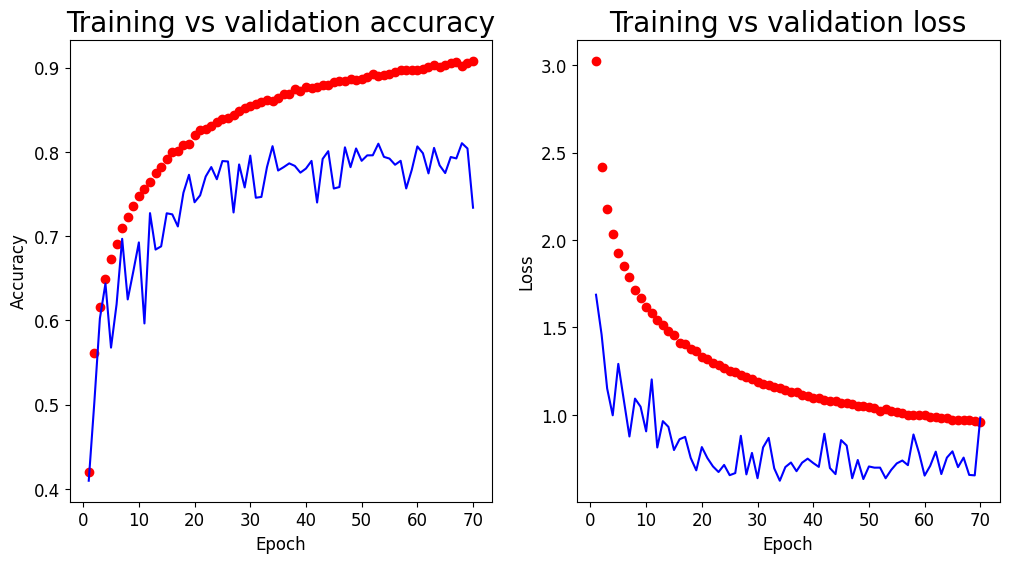

In [24]:
# Setting the parameters of the plots
plt.rcParams.update({'xtick.labelsize': 12,
                    'ytick.labelsize' : 12,
                    'axes.labelsize' : 12,
                    'axes.titlesize': 20,
                    'figure.figsize': (12, 6)})

# Take the evolution of the accuracy of the model on the training set
Training_acc = model_history.history['accuracy']

# Take the evolution of the accuracy of the model on the validation set
Validation_acc = model_history.history['val_accuracy']

# Take the evolution of the loss of the model on the training set
Training_loss = model_history.history['loss']

# Take the evolution of the loss of the model on the validation set
Validation_loss = model_history.history['val_loss']

# Generating the range for the epochs for the x axis
epochs = range(1, len(Training_acc) + 1)


# Define dimensions for plot
f, axs = plt.subplots(1, 2)
axs = axs.flatten()

# Showing the distribution of the labels in the training set
axs[0].plot(range(1, 71), Training_acc, 'ro', label='Training accuracy' )
axs[0].plot(range(1, 71), Validation_acc, 'b', label='Validation accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training vs validation accuracy')

# Showing the distribution of the labels in the training set
axs[1].plot(range(1, 71), Training_loss, 'ro', label='Training loss' )
axs[1].plot(range(1, 71), Validation_loss, 'b', label='Validation loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training vs validation loss')

plt.show()


The plots above show that our model was correctly trained. The model's loss over the training and validation sets decreases over time, while the model's accuracy for both sets increases.


## Accuracy check - test set

Now we can see how the model performs on the test set. We would report how __many samples were taken at each of the network's early exits__, as well as the model's __overall accuracy__.

In [27]:
# Evaluate the model on the test set
Model_EE.Custom_evaluate(X_test, y_test, batch_size = 256)

40/40 [==============================] - 3s 67ms/step - loss: 1.0030 - accuracy: 0.7362

Classifying stats:  {'Early Exit 1': 1355, 'Early Exit 2': 3655, 'Output layer': 4990}


Overall, we can confirm that the model outperforms the test set in terms of predictive performance. What is particularly intriguing is that the __10000__ samples present in the network were classified as follows:
  
  - __1355__ samples classified by Early Exit 1 (EE1)
  
  - __3655__ samples classified by Early Exit 2 (EE2)

  - __4990__ samples classified by Output layer

As a result, we can confirm that more than half of the samples were classified along the way, and the output layer was not in charge of classifying all of the samples. This would save us some time and compute requirements.

## Confusion matrix - test set

We can also take a look at the __confusion matrix of the predictions in the early exits over__ the test set:

40/40 [==============================] - 3s 70ms/step


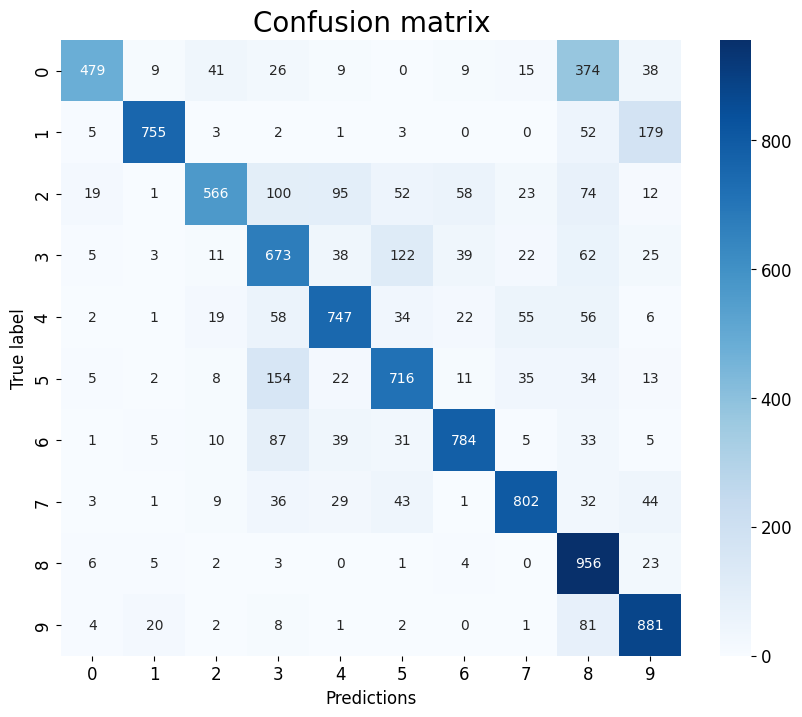

In [28]:
# Setting the parameters of the plots
plt.rcParams.update({'xtick.labelsize': 12,
                    'ytick.labelsize' : 12,
                    'axes.labelsize' : 12,
                    'axes.titlesize': 20,
                    'figure.figsize': (8, 6)})
# Get the logits of for the test data
y_pred = Model_EE.predict(X_test, batch_size = 256)[: , 0, :]

# Find the predicted class for each sample in the test data
y_pred = np.argmax(y_pred, axis=1)

# Form the confusion matrix based on the predicted label and the true label
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title("Confusion matrix")
plt.show()

In the plot above, we can also see the confusion matrix of our model's predictions in the presence of the Early Exits.